## CT5133 / CT5145 Deep Learning (/Online) 2022-2023

## Assignment 2

## James McDermott

* Student ID(s): 22225482
* Student name(s): Vijaya Vignesh Sankar

**Due date**: midnight Sunday 19 March (end Week 10).

**Weighting**: 20% of the module.

In this assignment the goal is to take advantage of pre-trained NN models to create an embedding with a dataset of movie posters, and demonstrate how to use that embedding.

The dataset is provided, along with some skeleton code for loading it.

The individual steps to be carried out are specified below, with `### YOUR CODE HERE` markers, together with the number of marks available for each part.

* **Topics**: in Part 5 below, students are asked to add some improvement to their models. In general, these improvements will differ between students (or student groups). **The proposed improvement must be notified to the lecturer at least 1 week before submission, and approved by the lecturer**. If working in a group, the two members of the group should not work on different topics in Part 5: they must work on the same topic and submit identical submissions.

* Students are not required to work incrementally on the parts. It is ok to do all the work in one day, so long as you abide by the rules on notifying groups and notifying topics.

* **Groups**: students may work solo or in a group of two. A student may not work together in a group with any student they have previously worked on a group project with, in this module or any other in the MSc programme. **Groups must be notified to the lecturer in writing before beginning work and at least 1 week before submission.** If working in a group, both students must submit and both submissions must be identical. If working in a group, both students may be asked to explain any aspect of the code in interview (see below), therefore working independently on separate components is not recommended. Any emails concerning the project should be cc-ed to the other group member.

* **Libraries**: code can be written in Keras/Tensorflow, or in PyTorch. 

* **Plagiarism**: students may discuss the assignment together, but you may not look at another student or group's work or allow other students to view yours (other than within a group). You may use snippets of code (eg 1-2 lines) from the internet, **if you provide a citation with URL**. You may also use a longer snippet of code if it is a utility function, again only with citation. You may not use code from the internet to carry out the core of the assignment. You may not use a large language model to generate code.

* **Submission**: after completing your work in this Jupyter notebook, submit the notebook both in `.ipynb` and `.pdf` formats. The content should be identical.

* **Interviews**: a number of students may be selected for interview, post-submission. The selection will depend on submissions, and random chance may be used also. Interviews will be held in-person (CT5133) or online (CT5145). Interviews will last approximately 10 minutes. The purpose of interviews will be to assess students' understanding of their own submission.


### Dataset Credits

The original csv file is from: 

https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

I have added the *year* column for convenience.

I believe most of the information is originally from the famous MovieLens dataset:

* https://grouplens.org/datasets/movielens/
* https://movielens.org/

However, I'm not clear whether the poster download URLs (Amazon AWS URLs) which are in the csv obtained from the Kaggle URL above are from a MovieLens source, or elsewhere.

To create the dataset we are using, I have randomly sampled a small proportion of the URLs in the csv, and downloaded the images. I have removed those which fail to download. Code below also filters out those which are in black and white, ie 1 channel only.

### Imports

You can add more imports if needed.

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform # useful for distances in the embedding

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [3]:
import random
from sklearn.manifold import TSNE

### Utility functions

These functions are provided to save you time. You might not need to understand any of the details here.

In [4]:
# walk the directory containing posters and read them in. all are the same shape: (268, 182).
# all have 3 channels, with a few exceptions (see below).
# each is named <imdbId>.jpg, which will later allow us to get the metadata from the csv.
IDs = []
images = []
for dirname, _, filenames in os.walk(r'D:\Users\OneDrive\Desktop\Assignment_2\DL_Sample'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs.append(ID)
            images.append(imnp)

In [5]:
img_array = np.array(images)

In [6]:
img_array.shape

(1238, 268, 182, 3)

In [7]:
# read the csv
df = pd.read_csv("Movie_Genre_Year_Poster.csv", encoding="ISO-8859-1", index_col="Unnamed: 0")
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,1995.0
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,1995.0
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0


In [8]:
df2 = df.drop_duplicates(subset=["imdbId"]) # some imdbId values are duplicates - just drop

In [9]:
df3 = df2.set_index("imdbId") # the imdbId is a more useful index, eg as in the next cell...

In [10]:
df4 = df3.loc[IDs] # ... we can now use .loc to take a subset

In [11]:
df4.shape # 1238 rows matches the image data shape above

(1238, 6)

In [12]:
df4

,Imdb Link,Title,IMDB Score,Genre,Poster,Year
imdbId,,,,,,
1000771,http://www.imdb.com/title/tt1000771,Recount (2008),7.5,Drama|History,https://images-na.ssl-images-amazon.com/images...,2008.0
100148,http://www.imdb.com/title/tt100148,Midnight Ride (1990),5.2,Action|Horror|Thriller,https://images-na.ssl-images-amazon.com/images...,1990.0
1001540,http://www.imdb.com/title/tt1001540,Perestroika (2009),4.5,Drama,https://images-na.ssl-images-amazon.com/images...,2009.0
100200,http://www.imdb.com/title/tt100200,Mr. & Mrs. Bridge (1990),6.7,Drama,https://images-na.ssl-images-amazon.com/images...,1990.0
1002563,http://www.imdb.com/title/tt1002563,The Young Messiah (2016),5.5,Drama,https://images-na.ssl-images-amazon.com/images...,2016.0
...,...,...,...,...,...,...
99611,http://www.imdb.com/title/tt99611,Frankenhooker (1990),6.1,Comedy|Horror,https://images-na.ssl-images-amazon.com/images...,1990.0
996967,http://www.imdb.com/title/tt996967,Otis (2008),6.1,Comedy|Crime|Horror,https://images-na.ssl-images-amazon.com/images...,2008.0
99726,http://www.imdb.com/title/tt99726,Hamlet (1990),6.8,Drama,https://images-na.ssl-images-amazon.com/images...,1990.0


In [13]:
years = df4["Year"].values
titles = df4["Title"].values
assert img_array.shape[0] == years.shape[0] == titles.shape[0]
assert all(np.isfinite(years)) # no missing values in years
print(years.min(), years.max())

1888.0 2016.0


In [14]:
def imread(filename):
    """Convenience function: we can supply an ID or a filename.
    We read and return the image in Image format.
    """
    path = r'D:\Users\OneDrive\Desktop\Assignment_2\DL_Sample'
    if type(filename) == int:
        # assume its an ID, so create filename
        filename = f"{path}\\{filename}.jpg"
        
    # now we can assume it's a filename, so open and read
    im = Image.open(filename)
    
    return im

def imshow(im):
    plt.figure()
    plt.imshow(im)
    plt.axis('off')

### Part 1. Create embedding [3 marks]

Use a pretrained model, eg as provided by Keras, to create a flat (ie 1D) embedding vector of some size `embedding_size` for each movie poster, and put all of these together into a single tensor of shape `(n_movies, embedding_size)`.

In [15]:
n_movies = img_array.shape[0]
embedding_size = 4
X = np.zeros((n_movies, embedding_size))

# Define the input shape for the model
input_shape = (224, 224, 3)

# Load the ResNet50 model pretrained on ImageNet
model_RES = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Loop over all the movie posters and compute their embeddings
for i in range(n_movies):
    # Load the movie poster and preprocess it for ResNet50
    x = img_array[i]
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Compute the embedding for the movie poster
    embedding = model_RES.predict(x)
    X[i] = embedding.flatten()[:embedding_size]

print(X.shape)


assert len(X.shape) == 2 # X should be (n_movies, embedding_size)
assert X.shape[0] == n_movies

1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 97ms/step
(1238, 4)


In [16]:
img_array.shape

(1238, 268, 182, 3)

### Part 2. Define a nearest-neighbour function [3 marks]

Write a function `def nearest(img, k)` which accepts an image `img`, and returns the `k` movies in the dataset whose posters are most similar to `img` (as measured in the embedding), ranked by similarity. 

In [17]:
def nearest(img, k):
    # Compute the embedding for img
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    img_embedding = model_RES.predict(x).flatten()[:4]

    # Compute the cosine similarity between img_embedding and all poster_embeddings
    similarity = cosine_similarity([img_embedding], X).flatten()

    # Sort the posters by similarity and return the k most similar ones
    most_similar= np.argsort(similarity)[::-1][:k]
    return most_similar

### Part 3: Demonstrate your nearest-neighbour function [4 marks]

Choose any movie poster. Call this the query poster. Show it, and use your nearest-neighbour function to show the 3 nearest neighbours (excluding the query itself). This means **call** the function you defined above.

Write a comment: in what ways are they similar or dissimilar? Do you agree with the choice and the ranking? Why do you think they are close in the embedding? Do you notice, for example, that the nearest neighbours are from a similar era? 


## My analysis:
 ## All the nearest neighbour posters have the word archive collections. Hence the nearest neighbour algorithm should have returned these posters as I use Cosine Similarity for similarity between images

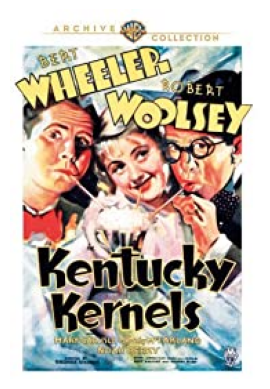

In [18]:
Q_idx = 25345
example_image = imread(Q_idx)
imshow(example_image)

In [19]:
most_similar_posters = nearest(example_image, k=4)

for poster in most_similar_posters:
    print(df4.iloc[poster])


1/1 [==============================] - 0s 95ms/step
Imdb Link                     http://www.imdb.com/title/tt25345
Title                                   Kentucky Kernels (1934)
IMDB Score                                                  6.1
Genre                                                    Comedy
Poster        https://images-na.ssl-images-amazon.com/images...
Year                                                     1934.0
Name: 25345, dtype: object
Imdb Link                     http://www.imdb.com/title/tt44324
Title                                   Above and Beyond (1952)
IMDB Score                                                  7.0
Genre                                    Action|Biography|Drama
Poster        https://images-na.ssl-images-amazon.com/images...
Year                                                     1952.0
Name: 44324, dtype: object
Imdb Link                     http://www.imdb.com/title/tt70851
Title                                     Ultimul cartus (1973

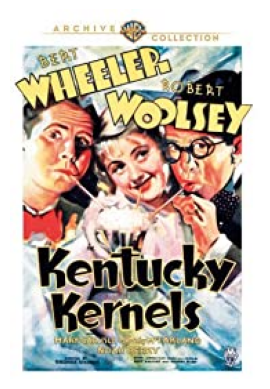

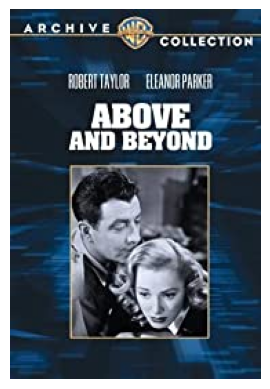

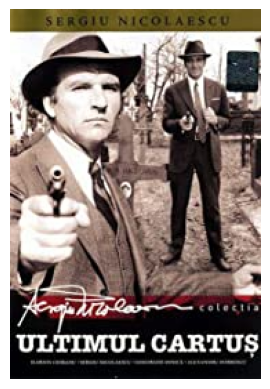

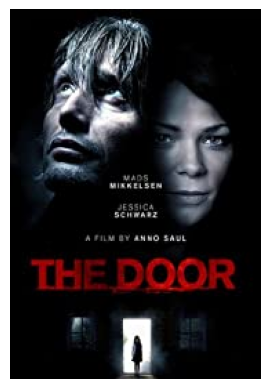

In [20]:
for poster in most_similar_posters:
    imshow(imread(IDs[poster]))

### Part 4: Year regression [5 marks]

Let's investigate the last question ("similar era") above by running **regression** on the year, ie attempt to predict the year, given the poster. Use a train-test split. Build a suitable Keras neural network model for this, **as a regression head on top of the embedding from Part 1**. Include comments to explain the purpose of each part of the model. It should be possible to make a prediction, given a new poster (not part of the original dataset). Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df4['Year'], test_size=0.2, random_state=42)

# Define the input shape for the model
input_shape = (4,)

# Define the model architecture
inputs = layers.Input(shape=input_shape, name='poster_embedding')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dropout(0.2, name='dropout_1')(x)
x = layers.Dense(32, activation='relu', name='dense_2')(x)
x = layers.Dropout(0.2, name='dropout_2')(x)
x = layers.Dense(16, activation='relu', name='dense_3')(x)
outputs = layers.Dense(1, activation='linear', name='year_prediction')(x)

# Create the model
model_reg = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(lr=0.001)
model_reg.compile(optimizer=optimizer, loss='mse')

# Train the model
model_reg.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
mse = model_reg.evaluate(X_test, y_test)
print(f"Test MSE: {mse:.2f}")

# Make predictions on a new poster
#new_poster_embedding = np.array([0.1, 0.2, 0.3, 0.4]) # replace with actual embedding
#predicted_year = model.predict(np.array([new_poster_embedding]))[0][0]
#print(f"Predicted year: {predicted_year:.0f}")


Epoch 1/100


C:\Users\Vj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


25/25 [==============================] - 1s 16ms/step - loss: 3969420.2500 - val_loss: 3970798.7500
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 3964247.0000 - val_loss: 3962145.5000
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 3949177.5000 - val_loss: 3934161.2500
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 3902854.2500 - val_loss: 3856377.0000
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 3786481.2500 - val_loss: 3677129.7500
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 3543072.7500 - val_loss: 3327050.2500
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 3102691.2500 - val_loss: 2754498.0000
Epoch 8/100
25/25 [==============================] - 0s 4ms/step - loss: 2452881.5000 - val_loss: 1978857.3750
Epoch 9/100
25/25 [==============================] - 0s 4ms/step - loss: 1671413.3750 - val_loss: 1172842.0000
Epoch 10/100

## Choosing a random movie ID and predicting its year

1/1 [==============================] - 0s 23ms/step
Predicted year: 1985
Actual Year: 1995


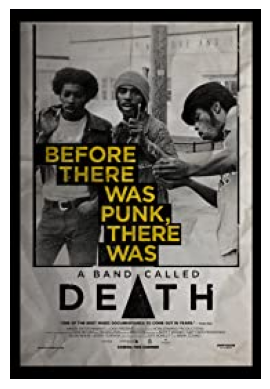

In [29]:
random_id = random.choice(IDs)
image_array = np.array([X[IDs.index(random_id)]])

predicted_year = model.predict(image_array)[0][0]
print(f"Predicted year: {predicted_year:.0f}")
actual_year = df.iloc[IDs.index(random_id)].Year
print(f"Actual Year: {actual_year:.0f}")
imshow(imread(random_id))

In this example, we first load the poster embeddings and year labels that were computed in Part 1, and split the data into training and testing sets using train_test_split. We then define a Keras neural network model that takes the poster embeddings as input, and predicts the year of the movie as a regression task. The model consists of several fully connected layers with ReLU activation, followed by a linear output layer. We compile the model using the mean squared error (MSE) loss and the Adam optimizer, and train the model on the training set using fit.

After training the model, we evaluate its performance on the test set using evaluate, and print the test MSE. Finally, we make a prediction on a new poster by computing its embedding and passing it to the model's predict method.

The model's performance on the test set will depend on the quality of the poster embeddings and the relationship between the posters and their release years in the dataset. If there is a strong correlation between the poster content and the year of release, the model may be able to make accurate predictions. However, if there are many outliers or noisy examples in the dataset, the model's performance may be limited. Additionally, it's worth noting that the model assumes a linear relationship between the poster embeddings and the year labels, which may not be the case in reality.

### Part 5: Improvements [5 marks]

Propose a possible improvement. Some ideas are suggested below. The chosen improvement must be notified to the lecturer at least 1 week before submission and **must be approved by the lecturer to avoid duplication with other students**. Compare the performance between your original and your new model (the proposed improvement might not actually improve on model performance -- that is ok). Some marks will be awarded for more interesting / challenging / novel improvements.

Ideas:

* Try a different pretrained model for creating the embedding
* Alternative ways of reducing the pretrained model's output to a flat vector for the embedding
* Gather more data (see the csv file for URLs)
* Add different architectural details to the regression head
* Fine-tuning
* Training an end-to-end convnet of your own design (no pretraining)
* Improve the embedding by training a multi-headed model, eg predicting both genre and year
* Create a good visualisation of the embedding.


1/1 [==============================] - 0s 24ms/step
Predicted year: 1963
Actual Year: 1955


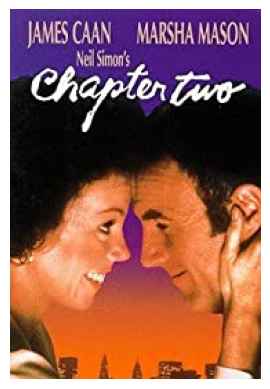

In [23]:
random_id = random.choice(IDs)
image_array = np.array([X[IDs.index(random_id)]])

predicted_year = model.predict(image_array)[0][0]
print(f"Predicted year: {predicted_year:.0f}")
actual_year = df.iloc[IDs.index(random_id)].Year
print(f"Actual Year: {actual_year:.0f}")
imshow(imread(random_id))

## My Improvement - build a customised non-prerained ConvNet and train 'end to end'

In [24]:
model_custom = models.Sequential()
model_custom.add(layers.Conv1D(32, 3, activation='relu', input_shape=(4, 1), padding='same'))
model_custom.add(layers.MaxPooling1D(pool_size=2))
model_custom.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
model_custom.add(layers.MaxPooling1D(pool_size=2))
model_custom.add(layers.Flatten())
model_custom.add(layers.Dense(64, activation='relu'))
model_custom.add(layers.Dense(1, activation='linear'))


# Compile the model
model_custom.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the model summary
model_custom.summary()

# Train the model
history = model_custom.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_mae = model_custom.evaluate(X_test, y_test)
print('Test Mean average error:', test_mae)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 32)             128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 32)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

## Predicting a random image with the Customized non-pretrained CNN mode

1/1 [==============================] - 0s 78ms/step
Predicted year: 1998
Actual Year: 1993


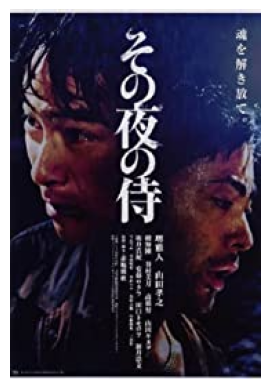

In [25]:
random_id = random.choice(IDs)
image_array = np.array([X[IDs.index(random_id)]])

predicted_year = model_custom.predict(image_array)[0][0]
print(f"Predicted year: {predicted_year:.0f}")
actual_year = df.iloc[IDs.index(random_id)].Year
print(f"Actual Year: {actual_year:.0f}")
imshow(imread(random_id))

## Comments & Final Observations:
    *The fully trained model that I built, for part 5, is having a less loss compared to that of the pretrained RESNET model ass we can see the mean average error is very much less compared to RES NET